## Lucas-Kanade Optical Flow Detector

In this notebook we demonstrate the use of optical flow detection based on [Lucas-Kanade algorithm](https://en.wikipedia.org/wiki/Lucas%E2%80%93Kanade_method). The algorithm is conceptually very similar to the Harris corner detector with the addition of the temporal luminance gradient. Optical flow helps us to estimate motion on a video and, as a consequence, it allows us to track keypoints across the video frames.

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

### Initialisation

We will use the Shi-Tomasi corner detector which is an enhanced variant of the famous Harris detector. You can learn more about the Shi-Tomasi detector by reading the original [paper](https://users.cs.duke.edu/~tomasi/papers/shi/TR_93-1399_Cornell.pdf) or having a look at the very comprehensible OpenCV [tutorial](https://docs.opencv.org/3.4/d4/d8c/tutorial_py_shi_tomasi.html). The video used in this notebook can be found [here]( https://www.bogotobogo.com/python/OpenCV_Python/images/mean_shift_tracking/slow_traffic_small.mp4).

In [2]:
video = cv2.VideoCapture('slow_traffic_small.mp4')

# ShiTomasi corner detection
config_st = {'maxCorners': 100,
             'qualityLevel': 0.3,
             'minDistance': 7,
             'blockSize': 7}

# Lucas-Kanade optical flow
config_lk = {'winSize': (15, 15),
             'maxLevel': 2,
             'criteria': (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)}

### Find Initial Keypoints to Track

In [3]:
# Create some random colors
color = np.random.randint(0, 255, (100, 3))

# Take first frame and find keypoints
ret, source = video.read()
assert ret

src_gray = cv2.cvtColor(source, cv2.COLOR_BGR2GRAY)
p_src = cv2.goodFeaturesToTrack(src_gray, mask=None, **config_st)

In order to better illustrate the optical flow detector in work, we will not apply in a frame by frame basis. Instead, we "fast forward" the video by several milliseconds so the perceived motion is larger. 

In [4]:
# Fast forward by 40 frames
for _ in range(40):
    ret, frame = video.read()
    assert ret

### Estimate Optical Flow

We will now use the Lucas-Kanade algorithm to estimate the optical flow between two frames. We will also print the results on the frame in order to better illustrate the meaning of optical flow.

In [5]:
# Read next frame
ret, target = video.read()    
dst_gray = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)

# Calculate optical flow
p_dst, status, err = cv2.calcOpticalFlowPyrLK(src_gray, dst_gray, p_src, None, **config_lk)

# Select points that have been successfully tracked
if p_dst is not None:
    p_dst = p_dst[status==1]
    p_src = p_src[status==1]

Let's now draw the results.

In [6]:
# Create an empty mask image for drawing purposes
mask = np.zeros_like(source)
    
# Draw the tracks
for i, (dst, src) in enumerate(zip(p_dst, p_src)):
    x_dst, y_dst = dst
    x_src, y_src = src
    
    mask = cv2.arrowedLine(mask, (int(x_src), int(y_src)), (int(x_dst), int(y_dst)),
                           color[i].tolist(), 2, tipLength=0.5)    
    target = cv2.circle(target, (int(x_src), int(y_src)), 5, color[i].tolist(), -1)

result = cv2.add(target, mask)

(<AxesSubplot:title={'center':'Target'}>,
 Text(0.5, 1.0, 'Target'))

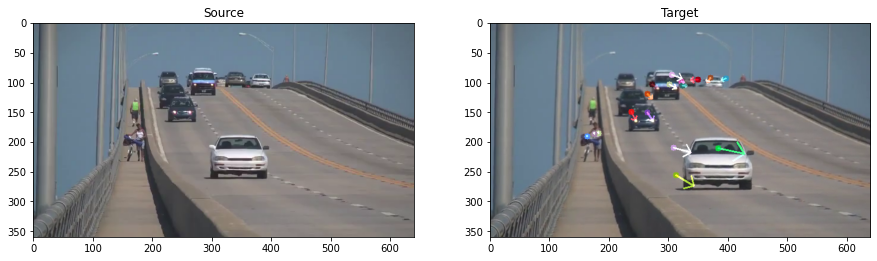

In [7]:
plt.subplot(121), plt.imshow(cv2.cvtColor(source, cv2.COLOR_BGR2RGB)), plt.title('Source')
plt.subplot(122), plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB)), plt.title('Target')

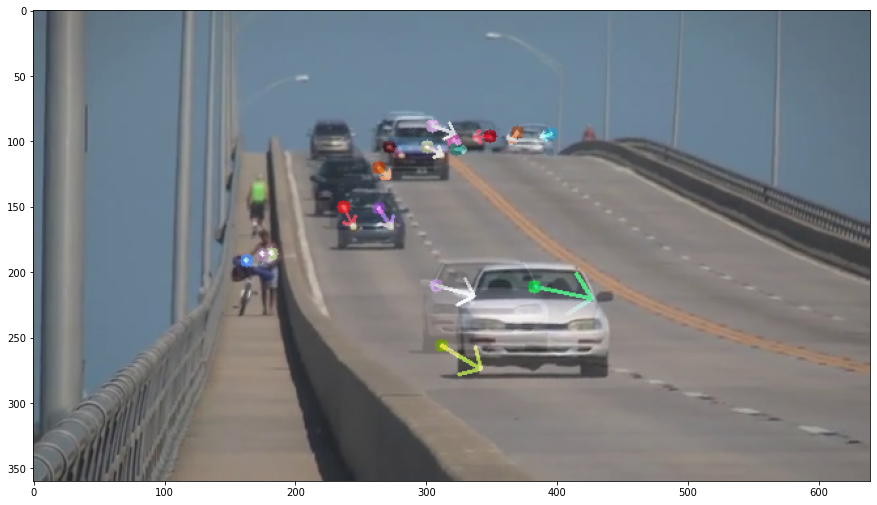

In [8]:
compound = cv2.addWeighted(result, 0.75, source, 0.25, gamma=0)
plt.imshow(cv2.cvtColor(compound, cv2.COLOR_BGR2RGB))